In [15]:
import warnings
warnings.filterwarnings('ignore')

In [16]:
import numpy as np
import pandas as pd

from scipy.stats import entropy
from copy import deepcopy as copy

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array, as_float_array

from sklearn.datasets import make_regression
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from lightgbm import LGBMClassifier

from scipy.stats import entropy
from scipy import sparse

import matplotlib.pyplot as plt

%matplotlib inline

In [17]:
class MaxentropyMedianDichtomizationTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_splits, verbose=False):
        self.n_splits = n_splits
        
        self.n_samples = None
        self.n_features = None
        self._splits = None
        self._splits_indices = None
    
    def _check_X(self, X, n_features=None):
        _X = None
        if not hasattr(X, 'dtype'):
            _X = check_array(as_float_array(X))
        _X = check_array(X)
        
        if self.n_features:
            if _X.shape[1] != self.n_features:
                raise Exception('X has {} columns while {} are expected'.format(_X.shape[1], self.n_features))
        return _X
    
    def _calc_entropy(self, X, split_bias):
        a = np.sum(X < split_bias)
        b = np.sum(X >= split_bias)

        p = np.array([a / X.shape[0], b / X.shape[0]])
        return -np.sum(np.log(p + 1) * p)


    def _get_maxentropy_split(self, X):
        # O(n^2)
        block_size = X.shape[0]
        ix_max_entropy = -1
        X_diff = np.diff(X)

        start_point = X.shape[0] // 2
        
        right_point = right_entropy = None
        left_point = left_entropy =None
        
        max_entropy = -1
        max_probas = None
        # define point where to start looking for
        # highest entropy
        if X_diff[start_point] == 0:
            _right_indices = np.where(X_diff[start_point:] > 0)[0]
            _left_indices = np.where(X_diff[:start_point] > 0)[0]
            
            if _right_indices.any():
                right_point = _right_indices[0] + start_point
            
            if _left_indices.any():
                left_point = _left_indices[-1]
            
            # if we have constant series
            if _right_indices is None and _left_indices is None:
                return 0, -1
            
            if right_point:
                right_entropy = self._calc_entropy(X, X[right_point])
        
            if left_point:
                left_entropy = self._calc_entropy(X, X[left_point])
        else:
            right_point = start_point + 1
            left_point = start_point - 1
            
            right_entropy = self._calc_entropy(X, X[right_point])
            left_entropy = self._calc_entropy(X, X[left_point])
            center_entropy = self._calc_entropy(X, X[start_point])
            
            if center_entropy > left_entropy and center_entropy > right_entropy:
                return center_entropy, start_point

        # if entropy at the point left to the starting point is higher
        # search for entropy maxima
        if right_point and  (not left_point or right_entropy > left_entropy):
            for j in range(right_point + 1, block_size):
                local_entropy = self._calc_entropy(X, X[j])
                if local_entropy > right_entropy:
                    right_point = j
                    right_entropy = local_entropy
                else:
                    return right_entropy, right_point
        elif left_point:
            for j in reversed(range(0, left_point - 1)):
                local_entropy = self._calc_entropy(X, X[j])
                if local_entropy > left_entropy:
                    left_point = j
                    left_entropy = local_entropy
                else:
                    return left_entropy, left_point
        
        return 0, -1

    def _dichtomize(self, X):
        # O(n^2 * log n)
        
        _iters = np.log2(self.n_splits)
        if _iters - int(_iters) != 0:
            raise Exception('number of bins should be of a power of 2')
        
        # make first maxentropy split
        _, initial_bin = self._get_maxentropy_split(X)
        splits_current_feature = [(0, initial_bin), (initial_bin, self.n_samples - 1)]
        for i in range(int(_iters) - 1):
            # an empty list for splits in current iteration
            _splits = list()
            for j in splits_current_feature:
                entropy, index = self._get_maxentropy_split(X[j[0]: j[1]])
                if entropy == 0:
                    _splits += [(j[0], j[1])]
                else:
                    _splits += [(j[0], j[0] + index), (j[0] + index, j[1])]

            splits_current_feature = _splits
            
        return splits_current_feature
    
    def _convert(self, X, ix):
        result = list()
        for x in X.flatten():
            result.append(np.argwhere([k[0] <= x and x < k[1] for k in self._splits[ix]]))
        return np.array(result).reshape(-1, 1) 
    
    def fit(self, X):
        X = self._check_X(X)
        self.n_samples, self.n_features = X.shape
        
        self._splits = list()
        self._splits_indices = list()
        
        for ix in range(self.n_features):
            x = np.sort(X[:, ix].flatten())
            _indices = self._dichtomize(x.flatten())
            
            self._splits_indices.append(_indices)
            self._splits.append([[x[i[0]], x[i[1]]] for i in _indices])
            
            self._splits[-1][0][0] = -np.inf
            self._splits[-1][-1][1] = np.inf
            
            self._splits = np.array(self._splits)
            
        return self
    
    def transform(self, X):
        _, n_features = X.shape
        X = self._check_X(X, n_features)
        
        X_categorical = list()
        for ix in range(n_features):
            X_categorical.append(self._convert(X, ix))
            
        return np.hstack(X_categorical)

In [84]:
class SomeFabulousTransformation(BaseEstimator):
    def __init__(self, base_estimator, dichtomized=False, n_splits=32, exhausitve=True, random_seed=42, verbose=1):
        self.base_estimator = base_estimator
        self.n_splits = n_splits
        self.random_seed = random_seed
        self.exhausitve = exhausitve
        self.verbose = verbose
        self.dichtomized=dichtomized
        self._feature_space = None
        self._feature_dichtomizers = None
        
    @staticmethod
    def _cross_entropy(p, q):
        p = np.array(p)
        q = np.array(q)
        q[q == 0] = 1e-9
        return -np.sum(p * np.log(q))
    
    @staticmethod
    def _synchronize_two_dicts(_from:dict, _to:dict):
        for i in np.setdiff1d(list(_from.keys()), list(_to.keys())):
            if i not in _to.keys():
                _to[i] = 0
            
            if i not in _from.keys():
                _from[i] = 0
            
    def _dichtomize(self, X):
        self._feature_dichtomizers = list()
        self._feature_space = list()
        
        if not self.dichtomized:
            for i in range(X.shape[1]):
                feature = X[:, i].reshape(-1, 1)
                dichtomizer = MaxentropyMedianDichtomizationTransformer(32).fit(feature)
                feature_dichtomized = dichtomizer.transform(feature)
                onehot_encoder = OneHotEncoder(sparse=True).fit(feature_dichtomized)

                self._feature_dichtomizers.append({'dichtomizer': dichtomizer, 'encoder': onehot_encoder})
                self._feature_space.append({'categorical': feature_dichtomized, 'binary': onehot_encoder.transform(feature_dichtomized)})
        else:
            for i in range(X.shape[1]):
                feature = X[:, i].reshape(-1, 1)
                onehot_encoder = OneHotEncoder(sparse=True).fit(feature)
                self._feature_dichtomizers.append({'dichtomizer': None, 'encoder': onehot_encoder})
                self._feature_space.append({'categorical': feature, 'binary': onehot_encoder.transform(feature)})
                
    
    def _calc_cross_entropy(self, ix_feature, pred, dataset_size):
        real = np.asarray(self._feature_space[ix_feature]['binary'].sum(1))
        pred = np.asarray(pred.sum(1))
        
        pred[np.argwhere(pred == 2)] = 1
        
        pred_category, pred_counts = np.unique(pred, return_counts=True)
        real_category, real_counts = np.unique(real, return_counts=True)

        pred_proba = pred_counts / dataset_size
        real_proba = real_counts / dataset_size

        real_stats = dict(zip(real_category, real_proba))
        pred_stats =  dict(zip(pred_category, pred_proba))

        SomeFabulousTransformation._synchronize_two_dicts(real_stats, pred_stats)
        
        return SomeFabulousTransformation._cross_entropy(list(real_stats.values()), list(pred_stats.values()))
    
    def _fit_transform(self, X, initial_feature_ix):
        dataset_size = X.shape[0]
        free_features_ix = [i for i in range(len(self._feature_space)) if i != initial_feature_ix]
        active_features_subset = [self._feature_space[initial_feature_ix]['binary']]
        active_features_subset_ix = [initial_feature_ix]
        
        while len(active_features_subset) != len(self._feature_space):
            max_entropy = -1
            max_entropy_feature_ix = -1
            max_entropy_feature_value = None
            
            if self.verbose > 1:
                print('currently processed {} features out of {}'.format(len(active_features_subset), len(self._feature_space)))
                print('number of active features {}'.format(len(active_features_subset)))
            
            for ix_current_feature in free_features_ix:
                if len(active_features_subset) > 1:
                    model_input_features = sparse.hstack(active_features_subset)
                else:
                    model_input_features = active_features_subset[0]
                
                estimator = copy(self.base_estimator)
                estimator.fit(model_input_features, self._feature_space[ix_current_feature]['categorical'].squeeze())
                
                pred = estimator.predict(model_input_features)

                pred_onehot = self._feature_dichtomizers[ix_current_feature]['encoder'].transform(pred.reshape(-1, 1))
                pred_diff = (pred_onehot != self._feature_space[ix_current_feature]['binary']).astype(np.int32)
                
                entropy = self._calc_cross_entropy(ix_current_feature, pred_diff, dataset_size)
                
                if entropy > max_entropy:
                    max_entropy_feature_value = pred_diff
                    max_entropy_feature_ix = ix_current_feature
                    max_entropy = entropy
                    
            free_features_ix.remove(max_entropy_feature_ix)
            active_features_subset.append(max_entropy_feature_value)
            active_features_subset_ix.append(max_entropy_feature_ix)
            
        return np.hstack(active_features_subset), active_features_subset_ix      
    
    def fit_transform(self, X):
        np.random.seed(self.random_seed)
        
        self._dichtomize(X)
        
        if not self.exhausitve:
            initial_feature_ix = np.random.randint(0, len(self._feature_space))
            return self._fit_transform(X, initial_feature_ix)
        
        features_subset = list()
        features_subset_ix = list()
        for initial_feature_ix in range(len(self._feature_space)):
            if self.verbose == 1:
                print('processing starting feature {}'.format(initial_feature_ix))
            _features_subset, _features_subset_ix = self._fit_transform(X, initial_feature_ix)
            
            features_subset.append(_features_subset)
            features_subset_ix.append(_features_subset_ix)
            
        return features_subset, np.vstack(features_subset_ix)

# Эксперимент на синтетике

In [96]:
X, y, coefs = make_regression(n_samples=1000, n_features=8, n_informative=4, n_targets=3, coef=True, random_state=42)
X = np.concatenate([X, y[:, :-1]], axis=1)
y = y[:, -1]#.reshape(-1, 1)

In [97]:
models = {
    'rf': LGBMClassifier(boosting_type='rf', bagging_freq=5, bagging_fraction=.05, feature_fraction=.1),
    'lr': LogisticRegression(random_state=42, multi_class='ovr', solver='liblinear', C=10000, tol=1e-2, n_jobs=-1),
    'svc': LinearSVC(multi_class='ovr'),
}

In [98]:
transform = SomeFabulousTransformation(models['lr'], exhausitve=True, verbose=True)

In [99]:
features, indices = transform.fit_transform(X)

processing starting feature 0
processing starting feature 1
processing starting feature 2
processing starting feature 3
processing starting feature 4
processing starting feature 5
processing starting feature 6
processing starting feature 7
processing starting feature 8
processing starting feature 9


In [100]:
indices

array([[0, 3, 6, 8, 5, 1, 7, 9, 4, 2],
       [1, 9, 6, 3, 8, 5, 0, 2, 4, 7],
       [2, 4, 3, 0, 8, 9, 6, 1, 7, 5],
       [3, 0, 4, 1, 8, 5, 7, 9, 2, 6],
       [4, 1, 5, 6, 9, 2, 8, 7, 3, 0],
       [5, 1, 7, 4, 9, 2, 8, 0, 6, 3],
       [6, 9, 1, 3, 4, 5, 8, 2, 0, 7],
       [7, 8, 6, 2, 0, 4, 9, 1, 5, 3],
       [8, 7, 6, 9, 0, 5, 2, 1, 4, 3],
       [9, 6, 1, 0, 8, 5, 7, 3, 4, 2]])

In [107]:
np.where(coefs.sum(1) > 0)[0].tolist() + [8, 9]

[0, 2, 4, 5, 8, 9]

In [108]:
unique_ix = np.unique(indices).tolist()
ix_counts = {i: 0 for i in unique_ix}

for row in indices:
    ranks = dict(zip(row.tolist(), reversed(range(row.shape[0]))))
    for i, j in ranks.items():
        ix_counts[i] += j / (row.shape[0]**2)

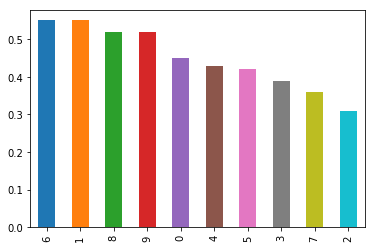

In [109]:
pd.Series(ix_counts).sort_values(ascending=False).plot(kind='bar')